# Predicting car prices using Turboaz data

## In this notebook I will try to compare the efficiency of selected machine learning algorithms in predicting car prices.

In [967]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [968]:
turboaz = pd.read_csv(r"C:\Users\azerk\Desktop\Data\turboaz.csv")
turboaz.head()

,Sheher,Marka,Model,Buraxilish ili,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,Oturucu,Yeni,Qiymet,Extra Info,Seller comment
0,Sumqayıt,Mercedes,C 200,1999,Sedan,Qara,2.0 L,175 a.g.,Benzin,366 000 km,Avtomat,Arxa,Xeyr,12500 AZN,Kreditdədir,Barter mümkündür
1,Bakı,Mercedes,C 180,2014,Sedan,Qara,1.6 L,167 a.g.,Benzin,102 000 km,Avtomat,Arxa,Xeyr,31500 $,Barter mümkündür,"Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkə..."
2,Sumqayıt,Mercedes,C 240,2002,Sedan,Qara,2.6 L,177 a.g.,Benzin,469 700 km,Avtomat,Arxa,Xeyr,11700 AZN,Kreditdədir,Barter mümkündür
3,Şirvan,Mercedes,C 180,1998,Sedan,Göy,1.8 L,125 a.g.,Benzin,556 680 km,Avtomat,Arxa,Xeyr,9700 AZN,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",Mawin BAKIDADI. Tecili satilir yaxwi veziyetde...
4,Sumqayıt,Mercedes,C 220,2000,Sedan,Gümüşü,2.2 L,150 a.g.,Dizel,300 000 km,Avtomat,Arxa,Xeyr,12700 AZN,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Par...",Vurugu udari deyisen detali curuyu qetiyyen yo...


In [969]:
# Dropping the duplicate values

turboaz.drop_duplicates(inplace=True)
turboaz.reset_index(drop=True, inplace=True)
turboaz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 16 columns):
Sheher              1027 non-null object
Marka               1027 non-null object
Model               1027 non-null object
Buraxilish ili      1027 non-null int64
Ban novu            1027 non-null object
Reng                1027 non-null object
Muherrikin hecmi    1027 non-null object
Muherrikin gucu     1027 non-null object
Yanacaq novu        1027 non-null object
Yurush              1027 non-null object
Suretler qutusu     1027 non-null object
Oturucu             1027 non-null object
Yeni                1027 non-null object
Qiymet              1027 non-null object
Extra Info          1021 non-null object
Seller comment      1026 non-null object
dtypes: int64(1), object(15)
memory usage: 128.5+ KB


###  We have 6 null values in "Extra Info" column and 1 null value in "Seller comment" column. We need to drop them, since fillna may be problematic in the case of these 2 columns

In [970]:
turboaz.dropna(inplace=True)
turboaz.reset_index(drop=True, inplace=True)

In [971]:
# Let`s transform the year of manufacture column into the years of usage column

turboaz["Buraxilish iliaxilish ili"] = 2020 - turboaz["Buraxilish ili"]
turboaz.rename(columns={"Buraxilish ili": "Istifade muddeti"}, inplace=True)

### Now, we need to improve the shape of the dataset. Some columns include both numbers and letters, which is not acceptable

In [972]:
qiymetsplitted = turboaz["Qiymet"].str.split()
hecmsplitted = turboaz["Muherrikin hecmi"].str.split()
gucsplitted = turboaz["Muherrikin gucu"].str.split()
yurushsplitted = turboaz["Yurush"].str.split()

# removing the L letter from the data in the "muherrikin hecmi" column
for index, row in turboaz.iterrows():
     turboaz.at[index, 'Muherrikin hecmi'] = hecmsplitted[index][0] 

In [973]:
# removing a.g. from the data in the "muherrikin gucu" column
for index, row in turboaz.iterrows():
     turboaz.at[index, 'Muherrikin gucu'] = gucsplitted[index][0]

In [974]:
# removing km from the data in the "Yurush column"
for index, row in turboaz.iterrows():
    if yurushsplitted[index][1]=="km":
        turboaz.at[index, 'Yurush'] = yurushsplitted[index][0]
    else:
        turboaz.at[index, 'Yurush'] = yurushsplitted[index][0]+yurushsplitted[index][1]

In [975]:
# We need to removing the currency label from the "qiymet" column, but we also need to tranform the entries in usd into azn.
# First, let`s make sure that there are entries only in 2 currencies:

for index, row in turboaz.iterrows():
     turboaz.at[index, 'Mezenne'] = qiymetsplitted[index][1]
        
turboaz["Mezenne"].value_counts()

AZN    980
$       40
Name: Mezenne, dtype: int64

In [976]:
# now we can drop the temporarily created "mezenne" column
turboaz.drop(columns=["Mezenne"], inplace=True)

In [977]:
# Converting the usd to azn

for index, row in turboaz.iterrows():
    if qiymetsplitted[index][1] == "AZN":
        turboaz.at[index, 'Qiymet'] = int(qiymetsplitted[index][0])
    elif qiymetsplitted[index][1] == "$":
        turboaz.at[index, 'Qiymet'] = int(qiymetsplitted[index][0])*1.7
        
turboaz["Qiymet"] = pd.to_numeric(turboaz.Qiymet)

## Let\`s start analyzing the categorical features. Some of them may contain less information than we desire to collect

In [978]:
turboaz["Yeni"].value_counts(normalize=True)

Xeyr    0.996078
Bəli    0.003922
Name: Yeni, dtype: float64

In [979]:
# 99.6% of the cars are used, so I decided to drop this column, since the variance is too low. 
turboaz.drop(columns=["Yeni"], inplace=True)

In [980]:
turboaz["Marka"].value_counts()

Mercedes    1020
Name: Marka, dtype: int64

In [981]:
turboaz.drop(columns=["Marka"], inplace=True)

In [982]:
turboaz["Oturucu"].value_counts()

Arxa    977
Tam      26
Ön       17
Name: Oturucu, dtype: int64

In [983]:
turboaz.drop(columns=["Oturucu"], inplace=True)

In [984]:
turboaz["Muherrikin gucu"] = pd.to_numeric(turboaz["Muherrikin gucu"])
turboaz["Muherrikin hecmi"] = pd.to_numeric(turboaz["Muherrikin hecmi"])
turboaz["Yurush"] = pd.to_numeric(turboaz["Yurush"])

In [985]:
turboaz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 14 columns):
Sheher                       1020 non-null object
Model                        1020 non-null object
Istifade muddeti             1020 non-null int64
Ban novu                     1020 non-null object
Reng                         1020 non-null object
Muherrikin hecmi             1020 non-null float64
Muherrikin gucu              1020 non-null int64
Yanacaq novu                 1020 non-null object
Yurush                       1020 non-null int64
Suretler qutusu              1020 non-null object
Qiymet                       1020 non-null float64
Extra Info                   1020 non-null object
Seller comment               1020 non-null object
Buraxilish iliaxilish ili    1020 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 111.7+ KB


### The dataset now looks a little bit cleaner, but still lots of work to do

In [986]:
turboaz.head(30)

,Sheher,Model,Istifade muddeti,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,Qiymet,Extra Info,Seller comment,Buraxilish iliaxilish ili
0,Sumqayıt,C 200,1999,Sedan,Qara,2.0,175,Benzin,366000,Avtomat,12500.0,Kreditdədir,Barter mümkündür,21
1,Bakı,C 180,2014,Sedan,Qara,1.6,167,Benzin,102000,Avtomat,53550.0,Barter mümkündür,"Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkə...",6
2,Sumqayıt,C 240,2002,Sedan,Qara,2.6,177,Benzin,469700,Avtomat,11700.0,Kreditdədir,Barter mümkündür,18
3,Şirvan,C 180,1998,Sedan,Göy,1.8,125,Benzin,556680,Avtomat,9700.0,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",Mawin BAKIDADI. Tecili satilir yaxwi veziyetde...,22
4,Sumqayıt,C 220,2000,Sedan,Gümüşü,2.2,150,Dizel,300000,Avtomat,12700.0,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Par...",Vurugu udari deyisen detali curuyu qetiyyen yo...,20
5,Bakı,C 230,1999,Sedan,Gümüşü,2.3,150,Benzin,200000,Avtomat,11200.0,"Yüngül lehimli disklər,ABS,Lyuk,Mərkəzi qapanm...",Maşın Təcili satılır. əla vəziyyətdədir.heç bi...,21
6,Bakı,C 240,1998,Sedan,Qara,2.4,170,Benzin,187000,Avtomat,13800.0,Barter mümkündür,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",22
7,Bakı,C 230,1998,Sedan,Qara,2.3,150,Qaz,309200,Avtomat,11400.0,"Yüngül lehimli disklər,ABS,Lyuk,Kondisioner,Də...",salam mercedes c230 kompressor avtomobili sat...,22
8,Lənkəran,C 200,1994,Sedan,Gümüşü,2.0,111,Benzin,426872,Avtomat,8500.0,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",Masin saz veziyetdedi hec bir xerc teleb edmir...,26
9,Bakı,C 200,1999,Sedan,Qırmızı,2.0,136,Benzin,240000,Avtomat,6800.0,Kreditdədir,Barter mümkündür,21


### We need to get deeper into our categorical features. I believe we can make them less complex

In [987]:
turboaz.Sheher.unique()

array(['Sumqayıt', 'Bakı', 'Şirvan', 'Lənkəran', 'Gəncə', 'Qax',
       'Zaqatala', 'Salyan', 'Qazax', 'Ağdam', 'İsmayıllı', 'Cəlilabad',
       'Füzuli', 'Şamaxı', 'Saatlı', 'Samux', 'Quba', 'Göyçay', 'İmişli',
       'Naftalan', 'Xırdalan', 'Oğuz', 'Bərdə', 'Şəki', 'Xudat', 'Ucar',
       'Şabran', 'Mingəçevir', 'Xaçmaz', 'Biləsuvar', 'Balakən', 'Qusar',
       'Ağstafa', 'Astara', 'Kürdəmir', 'Ağsu', 'Tərtər', 'Şəmkir',
       'Ağdaş', 'Masallı', 'Sabirabad', 'Tovuz', 'Beyləqan', 'Neftçala',
       'Goranboy', 'Ağcabədi', 'Şuşa', 'Yevlax', 'Göygöl', 'Naxçıvan',
       'Qobustan'], dtype=object)

In [988]:
turboaz.Sheher.value_counts()

Bakı          654
Sumqayıt      116
Gəncə          42
Şirvan         16
Xırdalan       13
Bərdə           9
Mingəçevir      9
Lənkəran        9
Göyçay          8
Xaçmaz          8
Quba            8
Masallı         7
Balakən         6
Qax             6
Cəlilabad       6
Qusar           6
Sabirabad       5
Ağdam           5
Salyan          5
İmişli          5
Ağsu            4
Qazax           4
Şəki            4
Ağcabədi        4
Biləsuvar       4
Saatlı          4
Kürdəmir        4
İsmayıllı       3
Ucar            3
Astara          3
Ağdaş           3
Goranboy        3
Şəmkir          3
Zaqatala        3
Şamaxı          2
Naftalan        2
Beyləqan        2
Tovuz           2
Tərtər          2
Yevlax          2
Ağstafa         2
Neftçala        2
Oğuz            2
Göygöl          2
Samux           2
Şuşa            1
Füzuli          1
Xudat           1
Qobustan        1
Naxçıvan        1
Şabran          1
Name: Sheher, dtype: int64

### We have lots of categories. We have to decrease the number of categories in order to avoid the overfitting

In [989]:
# I decided to leave the cars from "Baki" as a single category, since the majority of the cars in the dataset are from Baku
# I decided to join the entries from "Ganja" and "Sumqayit" into the single category.
# The the other cities/districts will be indicated as "Other"

turboaz.loc[turboaz.Sheher.isin(["Gəncə","Sumqayıt"]), 'Sheher'] = "Gəncə_Sumqayıt"
turboaz.loc[~turboaz.Sheher.isin(["Gəncə_Sumqayıt", "Bakı"]), "Sheher"] = "Diger"

In [990]:
turboaz.Sheher.value_counts()

Bakı              654
Diger             208
Gəncə_Sumqayıt    158
Name: Sheher, dtype: int64

In [991]:
turboaz.Model.value_counts()

C 180       325
C 200       195
C 240       147
C 220       143
C 230       123
C 250        29
C 280        24
C 300        17
C 320        12
C 32 AMG      2
C 63 AMG      1
C 30 AMG      1
C 270         1
Name: Model, dtype: int64

In [992]:
# Since the AMG versions are much more powerful than standard models, I decided to remove them
turboaz = turboaz.drop(turboaz[turboaz.Model.isin(["C 30 AMG", "C 32 AMG", "C 63 AMG"])].index)
turboaz.reset_index(drop=True, inplace=True)

In [993]:
turboaz.Model.value_counts()

C 180    325
C 200    195
C 240    147
C 220    143
C 230    123
C 250     29
C 280     24
C 300     17
C 320     12
C 270      1
Name: Model, dtype: int64

### I believe there are too many categories for this features. The models do not have that much of a difference. Even if they have, they will be reflected by other features. So, we can safely join the less frequent models into a single category

In [994]:
turboaz.loc[turboaz.Model.isin(["C 270", "C 320", "C 300", "C 280", "C 250"]), 'Model'] = "Diger modeller"

In [995]:
turboaz["Ban novu"].value_counts()

Sedan                877
Universal            132
Kupe                   4
Hetçbek / Liftbek      2
Offroader / SUV        1
Name: Ban novu, dtype: int64

### There have never been produced SUV versions of C class, so there is an error for sure. Moreover, we can replace the coupe and hatchbacks with sedans (mode).

In [996]:
turboaz = turboaz.drop(turboaz[turboaz["Ban novu"].isin(["Offroader / SUV"])].index)
turboaz.reset_index(drop=True, inplace=True)

In [997]:
turboaz.loc[turboaz["Ban novu"].isin(["Kupe", "Hetçbek / Liftbek"]), 'Ban novu'] = "Sedan"

### Let\`s check the color distribution

In [998]:
turboaz["Reng"].value_counts()

Gümüşü          281
Göy             212
Qara            197
Ağ               97
Yaşıl            62
Boz              55
Yaş Asfalt       34
Qızılı           27
Tünd qırmızı     14
Qırmızı          12
Bənövşəyi         9
Mavi              9
Qəhvəyi           4
Çəhrayı           2
Name: Reng, dtype: int64

### Same process will be repeated for this feature.

In [999]:
# Let`s group the colors
turboaz.loc[turboaz.Reng.isin(["Çəhrayı", "Qəhvəyi", "Bənövşəyi", "Qırmızı", "Tünd qırmızı", "Qızılı", "Yaşıl" ]), 'Reng'] = "Ekzotik"
turboaz.loc[turboaz.Reng.isin(["Mavi"]), 'Reng'] = "Göy"
turboaz.loc[turboaz.Reng.isin(["Yaş Asfalt", "Boz"]), 'Reng'] = "Gümüşü"

In [1000]:
turboaz["Reng"].value_counts()

Gümüşü     370
Göy        221
Qara       197
Ekzotik    130
Ağ          97
Name: Reng, dtype: int64

In [1001]:
turboaz["Yanacaq novu"].value_counts()

Benzin    900
Dizel     109
Qaz         6
Name: Yanacaq novu, dtype: int64

### Let\`s replace Qaz with Benzin

In [1002]:
turboaz.loc[turboaz["Yanacaq novu"].isin(["Qaz", "Yanacaq novu"]), 'Yanacaq novu'] = "Benzin"

In [1003]:
turboaz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 14 columns):
Sheher                       1015 non-null object
Model                        1015 non-null object
Istifade muddeti             1015 non-null int64
Ban novu                     1015 non-null object
Reng                         1015 non-null object
Muherrikin hecmi             1015 non-null float64
Muherrikin gucu              1015 non-null int64
Yanacaq novu                 1015 non-null object
Yurush                       1015 non-null int64
Suretler qutusu              1015 non-null object
Qiymet                       1015 non-null float64
Extra Info                   1015 non-null object
Seller comment               1015 non-null object
Buraxilish iliaxilish ili    1015 non-null int64
dtypes: float64(2), int64(4), object(8)
memory usage: 111.1+ KB


In [1004]:
turboaz.head(20)

,Sheher,Model,Istifade muddeti,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,Qiymet,Extra Info,Seller comment,Buraxilish iliaxilish ili
0,Gəncə_Sumqayıt,C 200,1999,Sedan,Qara,2.0,175,Benzin,366000,Avtomat,12500.0,Kreditdədir,Barter mümkündür,21
1,Bakı,C 180,2014,Sedan,Qara,1.6,167,Benzin,102000,Avtomat,53550.0,Barter mümkündür,"Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkə...",6
2,Gəncə_Sumqayıt,C 240,2002,Sedan,Qara,2.6,177,Benzin,469700,Avtomat,11700.0,Kreditdədir,Barter mümkündür,18
3,Diger,C 180,1998,Sedan,Göy,1.8,125,Benzin,556680,Avtomat,9700.0,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",Mawin BAKIDADI. Tecili satilir yaxwi veziyetde...,22
4,Gəncə_Sumqayıt,C 220,2000,Sedan,Gümüşü,2.2,150,Dizel,300000,Avtomat,12700.0,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Par...",Vurugu udari deyisen detali curuyu qetiyyen yo...,20
5,Bakı,C 230,1999,Sedan,Gümüşü,2.3,150,Benzin,200000,Avtomat,11200.0,"Yüngül lehimli disklər,ABS,Lyuk,Mərkəzi qapanm...",Maşın Təcili satılır. əla vəziyyətdədir.heç bi...,21
6,Bakı,C 240,1998,Sedan,Qara,2.4,170,Benzin,187000,Avtomat,13800.0,Barter mümkündür,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",22
7,Bakı,C 230,1998,Sedan,Qara,2.3,150,Benzin,309200,Avtomat,11400.0,"Yüngül lehimli disklər,ABS,Lyuk,Kondisioner,Də...",salam mercedes c230 kompressor avtomobili sat...,22
8,Diger,C 200,1994,Sedan,Gümüşü,2.0,111,Benzin,426872,Avtomat,8500.0,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",Masin saz veziyetdedi hec bir xerc teleb edmir...,26
9,Bakı,C 200,1999,Sedan,Ekzotik,2.0,136,Benzin,240000,Avtomat,6800.0,Kreditdədir,Barter mümkündür,21


## Now let\`s deal with the text columns

In [1005]:
# Now let`s create a column which will indicate the number of words used in the seller comment section

comments = turboaz["Seller comment"].str.split()
for index, row in turboaz.iterrows():
    turboaz.at[index, 'Comment_uzunluqu'] = len(comments[index])

In [1006]:
turboaz["Seller comment"].value_counts().head(10)

Barter mümkündür                                                                                                                                                                                             27
Yüngül lehimli disklər,ABS,Lyuk,Yağış sensoru,Mərkəzi qapanma,Park radarı,Kondisioner,Oturacaqların isidilməsi,Dəri salon,Ksenon lampalar,Arxa görüntü kamerası,Yan pərdələr,Oturacaqların ventilyasiyası     9
Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kondisioner                                                                                                                                                        6
Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkəzi qapanma,Kondisioner,Ksenon lampalar,Yan pərdələr                                                                                                             5
Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkəzi qapanma,Kondisioner                                                                                                    

In [1007]:
turboaz["Extra Info"].value_counts().head(10)

Barter mümkündür                                                                                                                                                                                             154
Kreditdədir                                                                                                                                                                                                   74
Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kondisioner                                                                                                                                                        46
Yüngül lehimli disklər,ABS,Lyuk,Mərkəzi qapanma,Kondisioner                                                                                                                                                   25
Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkəzi qapanma,Kondisioner                                                                                                

In [1008]:
# Decided to lowercase the entries in these 2 columns in order to make easier the process of feature engineering
turboaz["Seller comment"] = turboaz["Seller comment"].str.lower()
turboaz["Extra Info"] = turboaz["Extra Info"].str.lower()

In [1009]:
turboaz.head()

,Sheher,Model,Istifade muddeti,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,Qiymet,Extra Info,Seller comment,Buraxilish iliaxilish ili,Comment_uzunluqu
0,Gəncə_Sumqayıt,C 200,1999,Sedan,Qara,2.0,175,Benzin,366000,Avtomat,12500.0,kreditdədir,barter mümkündür,21,2.0
1,Bakı,C 180,2014,Sedan,Qara,1.6,167,Benzin,102000,Avtomat,53550.0,barter mümkündür,"yüngül lehimli disklər,abs,yağış sensoru,mərkə...",6,13.0
2,Gəncə_Sumqayıt,C 240,2002,Sedan,Qara,2.6,177,Benzin,469700,Avtomat,11700.0,kreditdədir,barter mümkündür,18,2.0
3,Diger,C 180,1998,Sedan,Göy,1.8,125,Benzin,556680,Avtomat,9700.0,"yüngül lehimli disklər,abs,mərkəzi qapanma,kon...",mawin bakidadi. tecili satilir yaxwi veziyetde...,22,33.0
4,Gəncə_Sumqayıt,C 220,2000,Sedan,Gümüşü,2.2,150,Dizel,300000,Avtomat,12700.0,"yüngül lehimli disklər,abs,mərkəzi qapanma,par...",vurugu udari deyisen detali curuyu qetiyyen yo...,20,30.0


In [1010]:
comment = turboaz["Seller comment"].str.split()
info = turboaz["Extra Info"].str.split(",")

In [1011]:
info[5]

['yüngül lehimli disklər',
 'abs',
 'lyuk',
 'mərkəzi qapanma',
 'kondisioner',
 'dəri salon',
 'ksenon lampalar']

### It seems like the "Extra info" is not filled manually by a user. It is chosen from a predefined list of extra details, so this column will be less problematic for us. I decided to create 3 binary features, indicating the presence of "lyuk, "deri salon" and "ksenon lampalar"

In [1012]:
for index, row in turboaz.iterrows():
    if "lyuk" in info[index]:
        turboaz.at[index, 'lyuk'] = 1
    else:
        turboaz.at[index, 'lyuk'] = 0

In [1013]:
for index, row in turboaz.iterrows():
    if "dəri salon" in info[index]:
        turboaz.at[index, 'deri salon'] = 1
    else:
        turboaz.at[index, 'deri salon'] = 0

In [1014]:
for index, row in turboaz.iterrows():
    if "ksenon lampalar" in info[index]:
        turboaz.at[index, 'ksenon lampalar'] = 1
    else:
        turboaz.at[index, 'ksenon lampalar'] = 0

In [1015]:
turboaz.head()

,Sheher,Model,Istifade muddeti,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,Qiymet,Extra Info,Seller comment,Buraxilish iliaxilish ili,Comment_uzunluqu,lyuk,deri salon,ksenon lampalar
0,Gəncə_Sumqayıt,C 200,1999,Sedan,Qara,2.0,175,Benzin,366000,Avtomat,12500.0,kreditdədir,barter mümkündür,21,2.0,0.0,0.0,0.0
1,Bakı,C 180,2014,Sedan,Qara,1.6,167,Benzin,102000,Avtomat,53550.0,barter mümkündür,"yüngül lehimli disklər,abs,yağış sensoru,mərkə...",6,13.0,0.0,0.0,0.0
2,Gəncə_Sumqayıt,C 240,2002,Sedan,Qara,2.6,177,Benzin,469700,Avtomat,11700.0,kreditdədir,barter mümkündür,18,2.0,0.0,0.0,0.0
3,Diger,C 180,1998,Sedan,Göy,1.8,125,Benzin,556680,Avtomat,9700.0,"yüngül lehimli disklər,abs,mərkəzi qapanma,kon...",mawin bakidadi. tecili satilir yaxwi veziyetde...,22,33.0,0.0,1.0,0.0
4,Gəncə_Sumqayıt,C 220,2000,Sedan,Gümüşü,2.2,150,Dizel,300000,Avtomat,12700.0,"yüngül lehimli disklər,abs,mərkəzi qapanma,par...",vurugu udari deyisen detali curuyu qetiyyen yo...,20,30.0,0.0,0.0,0.0


In [1016]:
turboaz["ksenon lampalar"].value_counts()

0.0    769
1.0    246
Name: ksenon lampalar, dtype: int64

In [1017]:
turboaz["lyuk"].value_counts()

0.0    540
1.0    475
Name: lyuk, dtype: int64

In [1018]:
for index, row in turboaz.iterrows():
    if "barter mümkündür" in info[index]:
        turboaz.at[index, 'barter mümkündür'] = 1
    else:
        turboaz.at[index, 'barter mümkündür'] = 0

In [1019]:
turboaz["barter mümkündür"].value_counts()

0.0    861
1.0    154
Name: barter mümkündür, dtype: int64

In [1020]:
for index, row in turboaz.iterrows():
    if "kreditdədir" in info[index]:
        turboaz.at[index, 'kreditdədir'] = 1
    else:
        turboaz.at[index, 'kreditdədir'] = 0

In [1021]:
turboaz["kreditdədir"].value_counts()

0.0    941
1.0     74
Name: kreditdədir, dtype: int64

### Now, it is getting a little more complicated. I could use tfidfvectorizer for text analyzing, but since our comments are in Azerbaijani, this process may be not that much efficient and produce some errors, so I will have to manually exctract some interesting features from "seller comment" column

In [1022]:
comment[3]

['mawin',
 'bakidadi.',
 'tecili',
 'satilir',
 'yaxwi',
 'veziyetdedir',
 'mator',
 'karopka',
 'most',
 'ela',
 'veziyetdedir',
 '.',
 'tek',
 'prablemi',
 'vozduxamer',
 'iwlemir',
 'oda',
 'ya',
 'pulundan',
 'cixaram',
 'yada',
 'alib',
 'qoyaram.',
 'bawqa',
 'prabelmi',
 'yoxdu',
 'otur',
 'sur',
 'mawindi',
 'real',
 'aliciya',
 'endirim',
 'olacaq.']

In [1023]:
for index, row in turboaz.iterrows():
    if "vurugu" in comment[index]:
        turboaz.at[index, 'vurulub'] = 1
    elif "vurug" in comment[index]:
        turboaz.at[index, 'vurulub'] = 1
    elif "vuruq" in comment[index]:
        turboaz.at[index, 'vurulub'] = 1
    elif "vuruqu" in comment[index]:
        turboaz.at[index, 'vurulub'] = 1
    else:
        turboaz.at[index, 'vurulub'] = 0

In [1024]:
turboaz.vurulub.value_counts()

0.0    923
1.0     92
Name: vurulub, dtype: int64

In [1025]:
for index, row in turboaz.iterrows():
    if "endirim" in comment[index]:
        turboaz.at[index, 'endirim_olacaq'] = 1
    else:
        turboaz.at[index, 'endirim_olacaq'] = 0

In [1026]:
turboaz.endirim_olacaq.value_counts()

0.0    942
1.0     73
Name: endirim_olacaq, dtype: int64

In [1027]:
for index, row in turboaz.iterrows():
    if "tecili" in comment[index]:
        turboaz.at[index, 'tecili'] = 1
    elif "təcili" in comment[index]:
        turboaz.at[index, 'tecili'] = 1  
    else:
        turboaz.at[index, 'tecili'] = 0

In [1028]:
turboaz.tecili.value_counts()

0.0    931
1.0     84
Name: tecili, dtype: int64

### We do not need the text columns anymore, so we can drop them and review our dataset

In [1029]:
turboaz.drop(columns=["Extra Info", "Seller comment"], inplace=True)
turboaz.reset_index(drop=True, inplace=True)
turboaz.head()

,Sheher,Model,Istifade muddeti,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,...,Buraxilish iliaxilish ili,Comment_uzunluqu,lyuk,deri salon,ksenon lampalar,barter mümkündür,kreditdədir,vurulub,endirim_olacaq,tecili
0,Gəncə_Sumqayıt,C 200,1999,Sedan,Qara,2.0,175,Benzin,366000,Avtomat,...,21,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Bakı,C 180,2014,Sedan,Qara,1.6,167,Benzin,102000,Avtomat,...,6,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Gəncə_Sumqayıt,C 240,2002,Sedan,Qara,2.6,177,Benzin,469700,Avtomat,...,18,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Diger,C 180,1998,Sedan,Göy,1.8,125,Benzin,556680,Avtomat,...,22,33.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,Gəncə_Sumqayıt,C 220,2000,Sedan,Gümüşü,2.2,150,Dizel,300000,Avtomat,...,20,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [1030]:
turboaz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 21 columns):
Sheher                       1015 non-null object
Model                        1015 non-null object
Istifade muddeti             1015 non-null int64
Ban novu                     1015 non-null object
Reng                         1015 non-null object
Muherrikin hecmi             1015 non-null float64
Muherrikin gucu              1015 non-null int64
Yanacaq novu                 1015 non-null object
Yurush                       1015 non-null int64
Suretler qutusu              1015 non-null object
Qiymet                       1015 non-null float64
Buraxilish iliaxilish ili    1015 non-null int64
Comment_uzunluqu             1015 non-null float64
lyuk                         1015 non-null float64
deri salon                   1015 non-null float64
ksenon lampalar              1015 non-null float64
barter mümkündür             1015 non-null float64
kreditdədir                  1015 non-nu

In [1031]:
# Creating dummy variables for our categorical features
turboaz = pd.get_dummies(turboaz, columns = ["Sheher", "Model", "Ban novu", "Reng", "Yanacaq novu", "Suretler qutusu"], drop_first=True, dtype="int64")

In [1032]:
turboaz = turboaz.astype(float)
turboaz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 29 columns):
Istifade muddeti             1015 non-null float64
Muherrikin hecmi             1015 non-null float64
Muherrikin gucu              1015 non-null float64
Yurush                       1015 non-null float64
Qiymet                       1015 non-null float64
Buraxilish iliaxilish ili    1015 non-null float64
Comment_uzunluqu             1015 non-null float64
lyuk                         1015 non-null float64
deri salon                   1015 non-null float64
ksenon lampalar              1015 non-null float64
barter mümkündür             1015 non-null float64
kreditdədir                  1015 non-null float64
vurulub                      1015 non-null float64
endirim_olacaq               1015 non-null float64
tecili                       1015 non-null float64
Sheher_Diger                 1015 non-null float64
Sheher_Gəncə_Sumqayıt        1015 non-null float64
Model_C 200               

### Our dataset looks much cleaner and "machine learning"-friendlier now

In [1033]:
turboaz.head()

,Istifade muddeti,Muherrikin hecmi,Muherrikin gucu,Yurush,Qiymet,Buraxilish iliaxilish ili,Comment_uzunluqu,lyuk,deri salon,ksenon lampalar,...,Model_C 230,Model_C 240,Model_Diger modeller,Ban novu_Universal,Reng_Ekzotik,Reng_Göy,Reng_Gümüşü,Reng_Qara,Yanacaq novu_Dizel,Suretler qutusu_Mexaniki
0,1999.0,2.0,175.0,366000.0,12500.0,21.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2014.0,1.6,167.0,102000.0,53550.0,6.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2002.0,2.6,177.0,469700.0,11700.0,18.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1998.0,1.8,125.0,556680.0,9700.0,22.0,33.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2000.0,2.2,150.0,300000.0,12700.0,20.0,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### We need to analyze the price column, which is our target

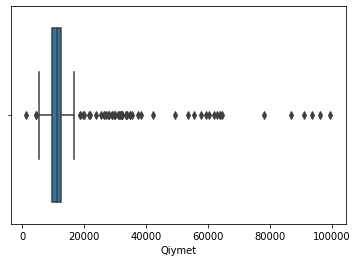

In [1034]:
import seaborn as sns
sns.boxplot(x=turboaz['Qiymet'])

### Seems like our target variable suffers from a bunch of outliers. We need to drop them in order to achieve normality of the target variable

In [1035]:
turboaz.Qiymet.describe()

count     1015.000000
mean     12405.320493
std       8798.359388
min       1130.000000
25%       9500.000000
50%      11200.000000
75%      12500.000000
max      99500.000000
Name: Qiymet, dtype: float64

In [1036]:
# According to the distribution, 75 percentile + IQR*1.5 = 17000 ; 25 percentile - IQR*1.5 = 5000
turboaz = turboaz.drop(turboaz[(turboaz['Qiymet'] > 17000) | (turboaz['Qiymet'] < 5000)].index)
turboaz.reset_index(drop=True, inplace=True)

### We need to make sure that our numerical features are normally distributed

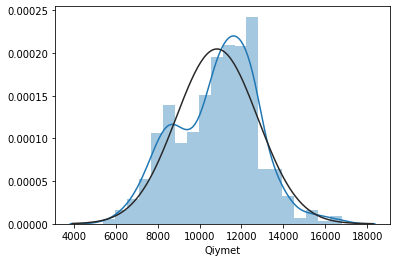

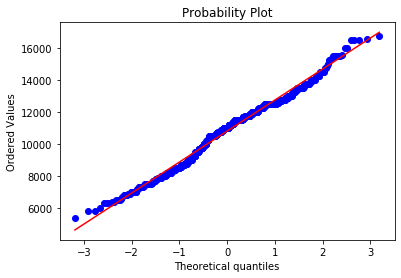

In [1037]:
from scipy import stats
from scipy.stats import norm

sns.distplot(turboaz['Qiymet'], fit=norm);
fig = plt.figure()
res = stats.probplot(turboaz['Qiymet'], plot=plt)

In [1038]:
print("Skewness: %f" % turboaz['Qiymet'].skew())
print("Kurtosis: %f" % turboaz['Qiymet'].kurt())

Skewness: -0.120832
Kurtosis: -0.184016


### The price column is normallly distrubuted

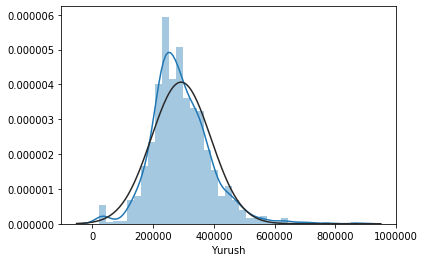

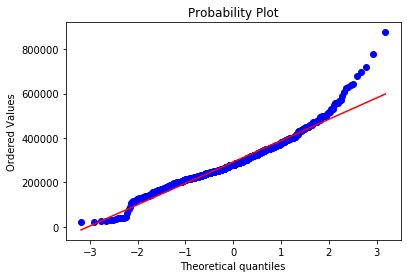

In [1039]:
sns.distplot(turboaz['Yurush'], fit=norm);
fig = plt.figure()
res = stats.probplot(turboaz['Yurush'], plot=plt)

In [1040]:
print("Skewness: %f" % turboaz['Yurush'].skew())
print("Kurtosis: %f" % turboaz['Yurush'].kurt())

Skewness: 0.883478
Kurtosis: 3.078396


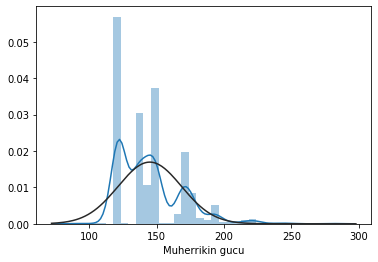

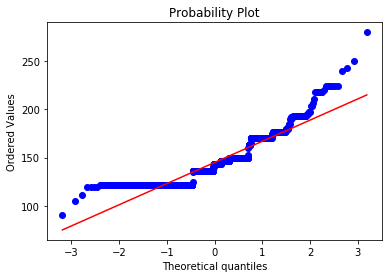

In [1041]:
sns.distplot(turboaz['Muherrikin gucu'], fit=norm);
fig = plt.figure()
res = stats.probplot(turboaz['Muherrikin gucu'], plot=plt)

In [1042]:
print("Skewness: %f" % turboaz['Muherrikin gucu'].skew())
print("Kurtosis: %f" % turboaz['Muherrikin gucu'].kurt())

Skewness: 1.234764
Kurtosis: 2.147597


In [1043]:
turboaz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 29 columns):
Istifade muddeti             962 non-null float64
Muherrikin hecmi             962 non-null float64
Muherrikin gucu              962 non-null float64
Yurush                       962 non-null float64
Qiymet                       962 non-null float64
Buraxilish iliaxilish ili    962 non-null float64
Comment_uzunluqu             962 non-null float64
lyuk                         962 non-null float64
deri salon                   962 non-null float64
ksenon lampalar              962 non-null float64
barter mümkündür             962 non-null float64
kreditdədir                  962 non-null float64
vurulub                      962 non-null float64
endirim_olacaq               962 non-null float64
tecili                       962 non-null float64
Sheher_Diger                 962 non-null float64
Sheher_Gəncə_Sumqayıt        962 non-null float64
Model_C 200                  962 non-null flo

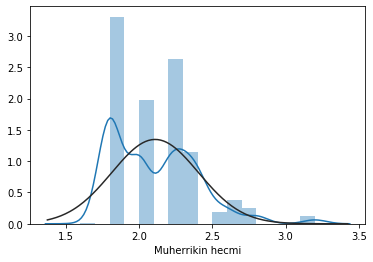

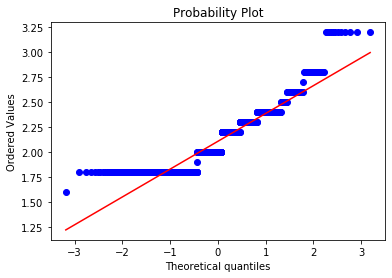

In [1044]:
sns.distplot(turboaz['Muherrikin hecmi'], fit=norm);
fig = plt.figure()
res = stats.probplot(turboaz['Muherrikin hecmi'], plot=plt)

In [1045]:
print("Skewness: %f" % turboaz['Muherrikin hecmi'].skew())
print("Kurtosis: %f" % turboaz['Muherrikin hecmi'].kurt())

Skewness: 0.891679
Kurtosis: 0.883951


### It seems like the normality is not a problem for us

Text(0, 0.5, 'Qiymet')

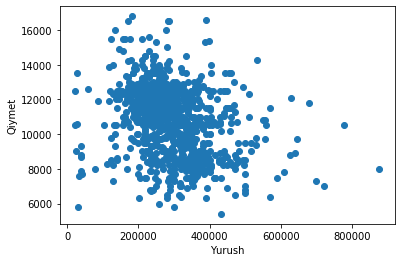

In [1046]:
plt.scatter(turboaz['Yurush'], turboaz['Qiymet'])
plt.xlabel("Yurush")
plt.ylabel("Qiymet")

Text(0, 0.5, 'Qiymet')

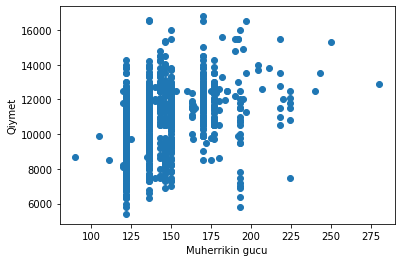

In [1047]:
plt.scatter(turboaz['Muherrikin gucu'], turboaz['Qiymet'])
plt.xlabel("Muherrikin gucu")
plt.ylabel("Qiymet")

Text(0, 0.5, 'Qiymet')

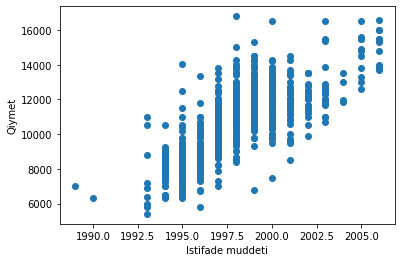

In [1048]:
plt.scatter(turboaz['Istifade muddeti'], turboaz['Qiymet'])
plt.xlabel("Istifade muddeti")
plt.ylabel("Qiymet")

Text(0, 0.5, 'Qiymet')

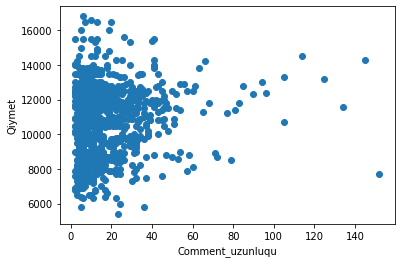

In [1049]:
plt.scatter(turboaz['Comment_uzunluqu'], turboaz['Qiymet'])
plt.xlabel("Comment_uzunluqu")
plt.ylabel("Qiymet")

In [1050]:
print("The importance of features relative to target")
corr = turboaz.corr().abs()
corr.sort_values(["Qiymet"], ascending = False, inplace = True)
print(corr.Qiymet)

The importance of features relative to target
Qiymet                       1.000000
Buraxilish iliaxilish ili    0.739304
Istifade muddeti             0.739304
Muherrikin gucu              0.349587
Muherrikin hecmi             0.304879
Suretler qutusu_Mexaniki     0.304013
Yurush                       0.274990
Yanacaq novu_Dizel           0.234103
Model_C 240                  0.229144
Reng_Ekzotik                 0.182959
ksenon lampalar              0.180518
deri salon                   0.176065
Model_C 230                  0.165451
Comment_uzunluqu             0.111803
Sheher_Diger                 0.094736
tecili                       0.082869
Ban novu_Universal           0.077668
vurulub                      0.063093
Sheher_Gəncə_Sumqayıt        0.046838
Model_C 220                  0.045779
Reng_Qara                    0.045525
kreditdədir                  0.028777
Model_Diger modeller         0.025657
lyuk                         0.020238
Model_C 200                  0.016290
bart

## Modeling

In [1051]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(turboaz.drop('Qiymet', axis=1), turboaz['Qiymet'], test_size=0.3, random_state=55)

In [1052]:
# I decided to standardize the coefficients

from sklearn.preprocessing import StandardScaler

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

scaler = StandardScaler() 

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

In [1053]:
X_train

array([[-0.020261  , -1.0483604 , -0.97537801, ..., -0.47760045,
        -0.34880749,  2.4368308 ],
       [-0.42130964, -1.0483604 , -0.97537801, ..., -0.47760045,
        -0.34880749, -0.41036908],
       [ 2.78707944,  1.40632442,  1.62399924, ...,  2.09380037,
        -0.34880749, -0.41036908],
       ...,
       [-0.42130964, -1.0483604 , -0.97537801, ..., -0.47760045,
        -0.34880749, -0.41036908],
       [-1.22340691, -1.0483604 , -0.97537801, ..., -0.47760045,
        -0.34880749,  2.4368308 ],
       [ 0.78183627, -0.34702188, -0.36885665, ..., -0.47760045,
        -0.34880749, -0.41036908]])

## Linear Regression

In [1054]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1055]:
lr.intercept_

array([-1.45083005e-14])

In [1056]:
lr.coef_

array([[ 0.33019121, -0.0505928 , -0.13275956, -0.10269238, -0.33019121,
         0.09785029, -0.0373011 , -0.01653591,  0.01665317, -0.01541751,
         0.03987998, -0.00057104, -0.02509157, -0.07539708,  0.0075943 ,
        -0.01192299,  0.10186891,  0.07493996,  0.16112523,  0.1852342 ,
         0.08802754, -0.00660489, -0.10832204, -0.03933726, -0.05725027,
        -0.09813968,  0.16408658, -0.16796498]])

In [1057]:
predictions = lr.predict(X_test).reshape(-1,1)

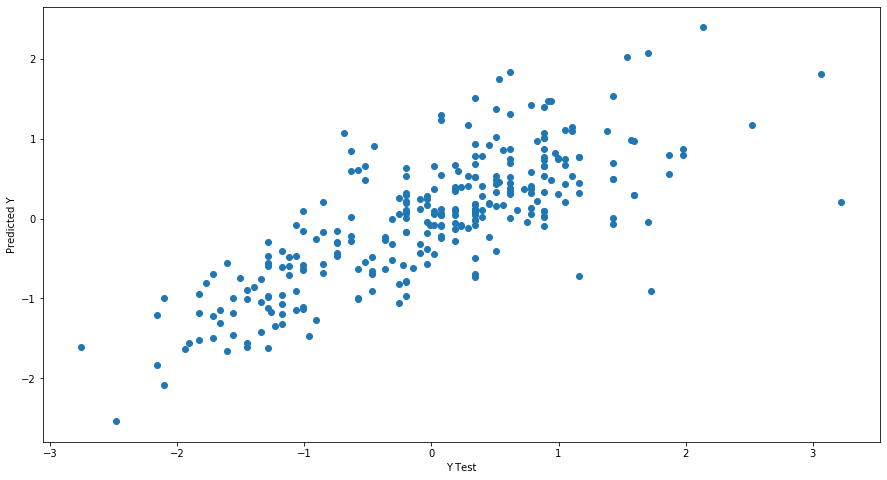

In [1058]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [1059]:
from sklearn import metrics
print('MAE is', metrics.mean_absolute_error(y_test, predictions))
print('MSE is', metrics.mean_squared_error(y_test, predictions))
print('RMSE is',np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE is 0.4847336399142136
MSE is 0.4110539719528915
RMSE is 0.6411349093232184


In [1060]:
metrics.r2_score(y_test, predictions)

0.5889460280471085

#### We can explain 58.9% of the variation in price through Linear Regression. I am sure we can do better

## Decision Tree Regression

In [1061]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 5)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best')

In [1062]:
dtr_pred= dtr.predict(X_test).reshape(-1,1)

In [1063]:
print('MAE is', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE is', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE is',np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE is 0.622996605419361
MSE is 0.7035508844223378
RMSE is 0.8387794015248216


In [1064]:
metrics.r2_score(y_test, dtr_pred)

0.2964491155776622

#### Unfortunately, this is a failure

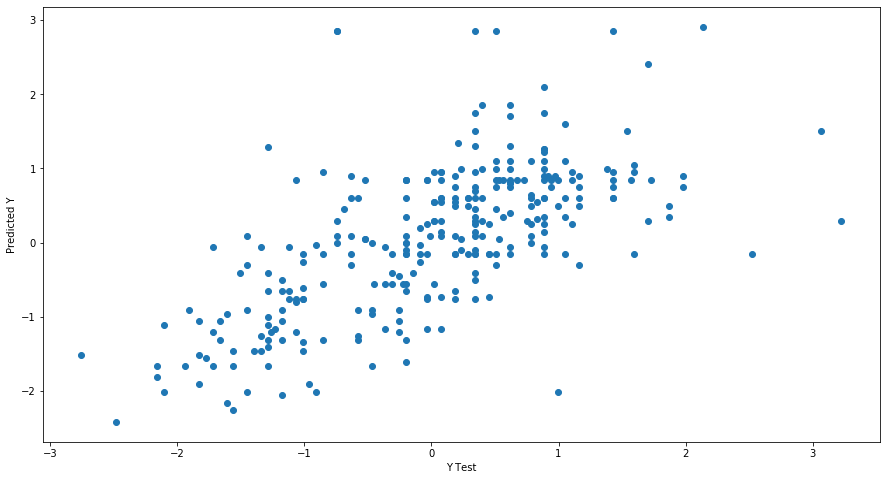

In [1065]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

## SVM Regression

In [1066]:
from sklearn.svm import SVR
svmr = SVR(kernel = 'rbf')
svmr.fit(X_train, y_train)

C:\Users\azerk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [1067]:
svmr_pred= svmr.predict(X_test).reshape(-1,1)

In [1068]:
print('MAE is', metrics.mean_absolute_error(y_test, svmr_pred))
print('MSE is', metrics.mean_squared_error(y_test, svmr_pred))
print('RMSE is',np.sqrt(metrics.mean_squared_error(y_test, svmr_pred)))

MAE is 0.46557335068744676
MSE is 0.38517170794011496
RMSE is 0.6206220330765859


In [1069]:
metrics.r2_score(y_test, svmr_pred)

0.6148282920598851

#### 61.5% is better, let\`s dig into it 

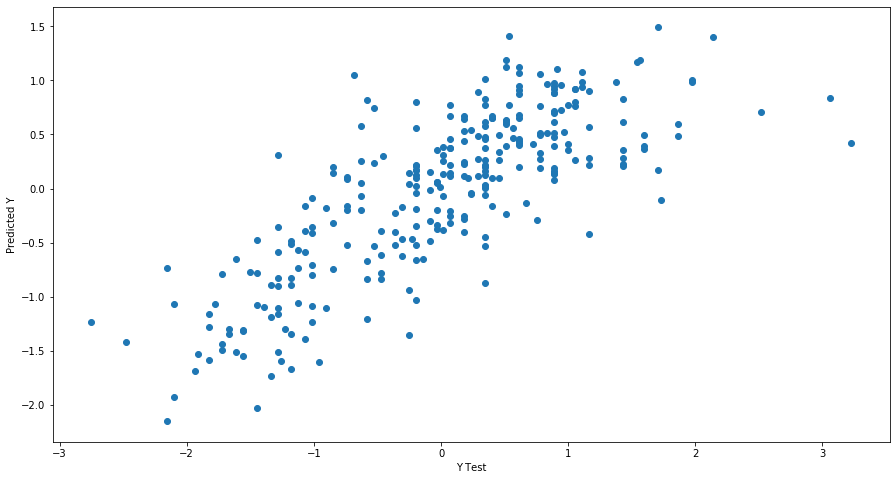

In [1070]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svmr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

## Random Forest Regressor

In [1071]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfr.fit(X_train, y_train)

C:\Users\azerk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [1072]:
rfr_pred = rfr.predict(X_test).reshape(-1,1)

In [1073]:
print('MAE is', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE is', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE is',np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

MAE is 0.4344725227764563
MSE is 0.3351500004941024
RMSE is 0.5789214113280855


In [1074]:
metrics.r2_score(y_test, rfr_pred)

0.6648499995058976

#### Even better

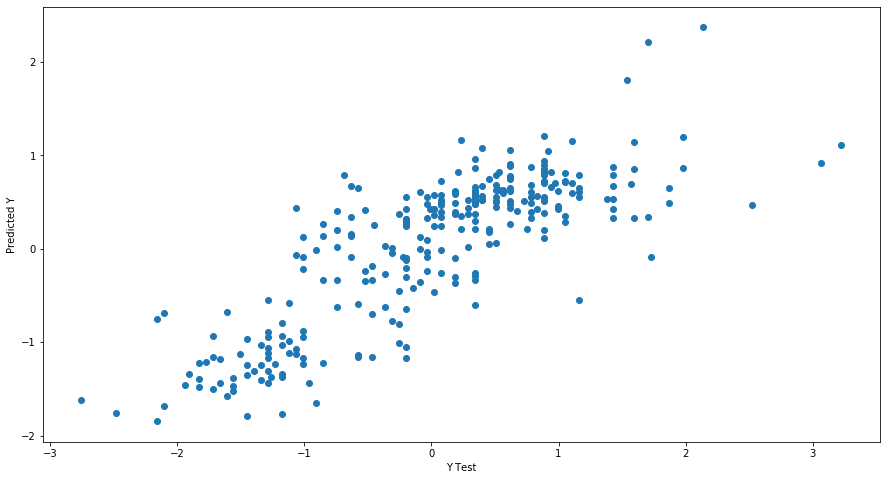

In [1075]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

## LightGBM

In [1076]:
!pip install lightgbm
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=750,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgb.fit(X_train,y_train)

C:\Users\azerk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.2319, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.05, max_bin=55,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=6, min_split_gain=0.0,
              min_sum_hessian_in_leaf=11, n_estimators=750, n_jobs=-1,
              num_leaves=5, objective='regression', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [1077]:
lgb_pred = model_lgb.predict(X_test).reshape(-1,1)


In [1078]:
print('MAE is', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE is', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE is',np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))

MAE is 0.4303805128967966
MSE is 0.3328371169530744
RMSE is 0.5769203731478673


In [1079]:
metrics.r2_score(y_test, lgb_pred)

0.6671628830469256

#### The  best model so far

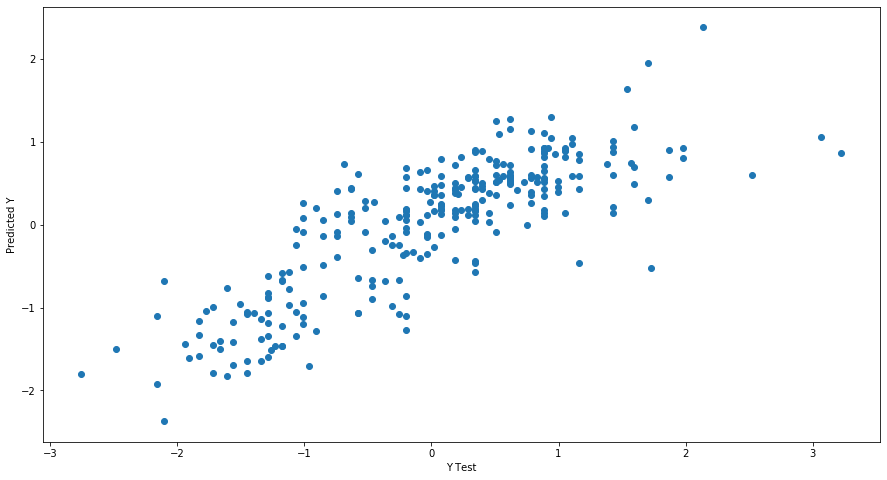

In [1080]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,lgb_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

## We observe that Random Forest and LightbGBM are the best algorithms for predicting car prices in our case. We can predict prices for the new dataset using these algoritghms. There is no doubt it that we can perform even better in the future